In [1]:
from IPython.display import display, Image
import ipywidgets as widgets
import threading
import torch
import torchvision
import cv2
import PIL.Image
import time
from cnn.center_dataset import TEST_TRANSFORMS


from jetcam.utils import bgr8_to_jpeg

In [2]:
from jetcam.csi_camera import CSICamera

camera = CSICamera(capture_width=1280, capture_height=720, downsample=2, capture_fps=30)

GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3280 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3280 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1640 x 1232 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 59.999999 fps Duration = 16666667 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: Running with following settings:
   Camera index = 0 
   Camera mode  = 4 
   Output Stream W = 1280 H = 7

[ WARN:0] global /home/ubuntu/build_opencv/opencv/modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1
[ WARN:0] global /home/ubuntu/build_opencv/opencv/modules/videoio/src/cap_gstreamer.cpp (1390) setProperty OpenCV | GStreamer warning: GStreamer: unhandled property


GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success
GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3280 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3280 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1640 x 1232 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 59.999999 fps Duration = 16666667 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: Running with following settings:
   

In [3]:
def get_model():
        model = torchvision.models.alexnet(num_classes=2, dropout=0.5)
        return model

def set_model(model) -> None:
        """
        Set a YOLO model
        """
        model = model

def preprocess(image: PIL.Image):
        device = torch.device('cuda')    
        image = TEST_TRANSFORMS(image).to(device)
        return image[None, ...]

device = torch.device('cuda')
model = get_model()
model.load_state_dict(torch.load('road_following_model_alexnet_3.pth'))
model = model.to(device)
set_model(model=model)

In [13]:
# Set a Kalman Filter parameters
A = 1
H = 1
Q = 0.87
R = 4
x = 0
P = 6

# Kalman filter
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [14]:

# Stop button
# ================
stopButton = widgets.Checkbox(
    value=False,
    description='Streaming',
    disabled=False,
    indent=False,
)

# Display function
# ================
def view(button):
    frame = camera.read()
    color_coverted = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = PIL.Image.fromarray(color_coverted)
    pil_width = pil_image.width
    pil_height = pil_image.height

    with torch.no_grad():
        image = preprocess(image=pil_image)
        output = model(image).detach().cpu().numpy()
    x, y = output[0]
    x_est = x
    P = 6
    x_est, P = kalman_filter(x,x_est,P)
    
    x = int((x_est / 2 + 0.5) * pil_width)
    y = int((y / 2 + 0.5) * pil_height)
    
    
    frame = cv2.circle(frame, (x,y), radius=3, color=(255, 0, 0), thickness=-1, lineType=None, shift=None)
    display_handle=display(Image(data=bgr8_to_jpeg(frame)), display_id=True)
    #time.sleep(0.1)
    while True:
         if stopButton.value:
            frame = camera.read()
            color_coverted = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = PIL.Image.fromarray(color_coverted)
            pil_width = pil_image.width
            pil_height = pil_image.height

            with torch.no_grad():
                image = preprocess(image=pil_image)
                output = model(image).detach().cpu().numpy()
            x, y = output[0]
            x_est, P = kalman_filter(x,x_est,P)
            x = int((x_est / 2 + 0.5) * pil_width)
            y = int((y / 2 + 0.5) * pil_height)
            frame = cv2.circle(frame, (x,y), radius=3, color=(255, 0, 0), thickness=-1, lineType=None, shift=None)
            display_handle.update(Image(data=bgr8_to_jpeg(frame)))


Checkbox(value=False, description='Streaming', indent=False)

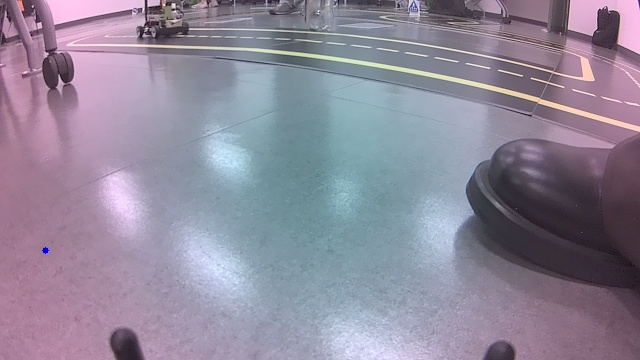

In [15]:
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

In [16]:
camera.release()

GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


Exception in thread Thread-9:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ircv9/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_8669/1150423599.py", line 36, in view
  File "/home/ircv9/HYU-2024-Embedded/jetracer/jetcam/camera.py", line 27, in read
    self.value = self._read()
  File "/home/ircv9/HYU-2024-Embedded/jetracer/jetcam/csi_camera.py", line 61, in _read
    raise RuntimeError('Could not read image from camera')
RuntimeError: Could not read image from camera
